# Physics-Informed Neural Network with Live Plotting

This notebook extends the feedforward PINN from the first script by adding **live plotting** and **frame saving**.  
The motivation was simple: I wanted to see in real-time how the learned trajectory evolves as the network improves its approximation of the damped oscillator.  

Instead of just seeing the final solution, live plotting shows *when* the network starts to "believe" in the correct frequency and damping.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import os

# Tanh is chosen since the target dynamics are smooth and oscillatory.
class SimpleFeedForwardNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Instantiate the model
model = SimpleFeedForwardNN()

## Learning physical parameters

As before, I parameterize \( m, k, c \) in log-space:

$$
m = e^{\hat{m}}, \quad k = e^{\hat{k}}, \quad c = e^{\hat{c}}
$$

This guarantees positivity during training.

In [2]:
# Parameters
# Starting guesses are intentionally different from true system params.
log_m_param = nn.Parameter(torch.tensor([np.log(0.5)]))
log_k_param = nn.Parameter(torch.tensor([np.log(1.0)]))
log_c_param = nn.Parameter(torch.tensor([np.log(0.2)]))

# Optimizer
optimizer = torch.optim.Adam(list(model.parameters()) + [log_m_param, log_k_param, log_c_param], lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)

# domain: time samples from 0 to 10
t_physics = torch.linspace(0, 10, steps=200, requires_grad=True).view(-1, 1)

# Ground-truth system params
m_true = 1.0
k_true = 2.0
c_true = 0.5

# Analytical solution of damped oscillator (x(0)=1, x'(0)=0)
gamma = c_true / (2 * m_true)
omega_prime = np.sqrt(k_true / m_true - gamma**2)
def analytical_solution(t):
    return np.exp(-gamma * t) * (np.cos(omega_prime * t) + (gamma / omega_prime) * np.sin(omega_prime * t))

# Experimental data: noisy samples from the analytical solution
t_data = torch.tensor([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]).view(-1, 1)
x_data = torch.tensor(analytical_solution(t_data.numpy())).float() + 0.01 * torch.randn_like(t_data)

## Live plotting setup
I used `matplotlib` together with `clear_output` from IPython to continuously update the same figure.  

At each checkpoint (every 500 epochs), I:
1. Evaluate the current network prediction,
2. Plot it against the analytical solution and data points,
3. Save the frame into `pinn_frames/` for later stitching into a GIF/video.

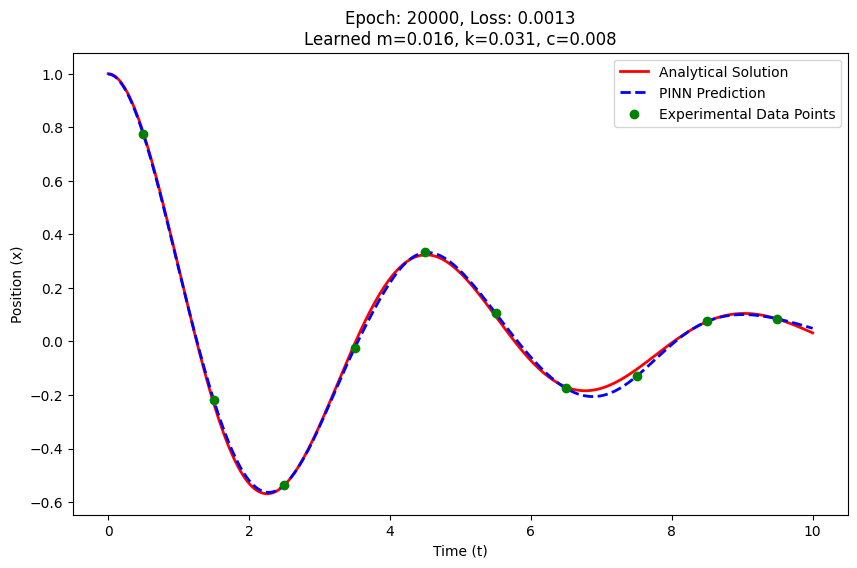

In [3]:
# Custom loss: enforces the governing ODE residual
def calculate_physics_loss(t, predicted_x, m, k, c):
    dx_dt = torch.autograd.grad(predicted_x, t, torch.ones_like(predicted_x), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t, torch.ones_like(dx_dt), create_graph=True)[0]
    equation_residual = m * d2x_dt2 + c * dx_dt + k * predicted_x
    return torch.mean(equation_residual**2)

# Training configuration
num_epochs = 20000
lambda_physics = 100.0   # weight for physics-informed residual
lambda_data = 1000.0     # weight for data mismatch

# Create folder for saving live plots
if not os.path.exists('pinn_frames'):
    os.makedirs('pinn_frames')

# Visualization setup
fig, ax = plt.subplots(figsize=(10, 6))
t_test = torch.linspace(0, 10, steps=300).view(-1, 1)
x_analytical = analytical_solution(t_test.numpy())

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Convert log-params back to physical values
    m = torch.exp(log_m_param)
    k = torch.exp(log_k_param)
    c = torch.exp(log_c_param)

    # Data mismatch loss
    x_data_predicted = model(t_data)
    loss_data = torch.mean((x_data_predicted - x_data)**2)

    # Initial condition loss: x(0) = 1, dx/dt(0) = 0
    t_initial = torch.tensor([[0.0]], requires_grad=True)
    x_initial_predicted = model(t_initial)
    loss_initial_pos = (x_initial_predicted - 1.0)**2
    dx_dt_initial_predicted = torch.autograd.grad(model(t_initial), t_initial, torch.ones_like(x_initial_predicted), create_graph=True)[0]
    loss_initial_vel = (dx_dt_initial_predicted - 0.0)**2
    loss_initial = loss_initial_pos + loss_initial_vel

    # Physics residual loss
    predicted_x_physics = model(t_physics)
    loss_phys = calculate_physics_loss(t_physics, predicted_x_physics, m, k, c)

    # Total loss combines all contributions
    total_loss = loss_initial + lambda_data * loss_data + lambda_physics * loss_phys

    total_loss.backward()
    optimizer.step()
    scheduler.step()

    # Periodic visualization and frame saving
    if (epoch + 1) % 500 == 0:
        model.eval()
        with torch.no_grad():
            x_predicted = model(t_test).numpy()

        clear_output(wait=True)
        ax.clear()
        ax.plot(t_test.numpy(), x_analytical, 'r-', label='Analytical Solution', linewidth=2)
        ax.plot(t_test.numpy(), x_predicted, 'b--', label='PINN Prediction', linewidth=2)
        ax.scatter(t_data.numpy(), x_data.numpy(), color='green', zorder=5, label='Experimental Data Points')
        ax.set_title(f'Epoch: {epoch+1}, Loss: {total_loss.item():.4f}\nLearned m={m.item():.3f}, k={k.item():.3f}, c={c.item():.3f}')
        ax.set_xlabel('Time (t)')
        ax.set_ylabel('Position (x)')
        ax.legend()
        ax.grid(False)

        # Save each frame for later (GIF/video)
        filename = f'pinn_frames/pinn_epoch_{epoch+1:05d}.png'
        fig.savefig(filename)

        display(fig)

        if (epoch + 1) == num_epochs:
            plt.close(fig)

## Training reflections
Watching the frames evolve gave me more intuition:
- Early on, the model overfits the few data points without satisfying physics.
- After several thousand epochs, the residual loss dominates and the predicted trajectory aligns with the analytical curve.
- The parameters \( m, k, c \) stabilize around their true values.

This visualization convinced me that the PINN isn’t just "memorizing data," but actually learning the underlying dynamics.


--- Training Finished ---
True m: 1.00, Learned m: 0.0155
True k: 2.00, Learned k: 0.0310
True c: 0.50, Learned c: 0.0080


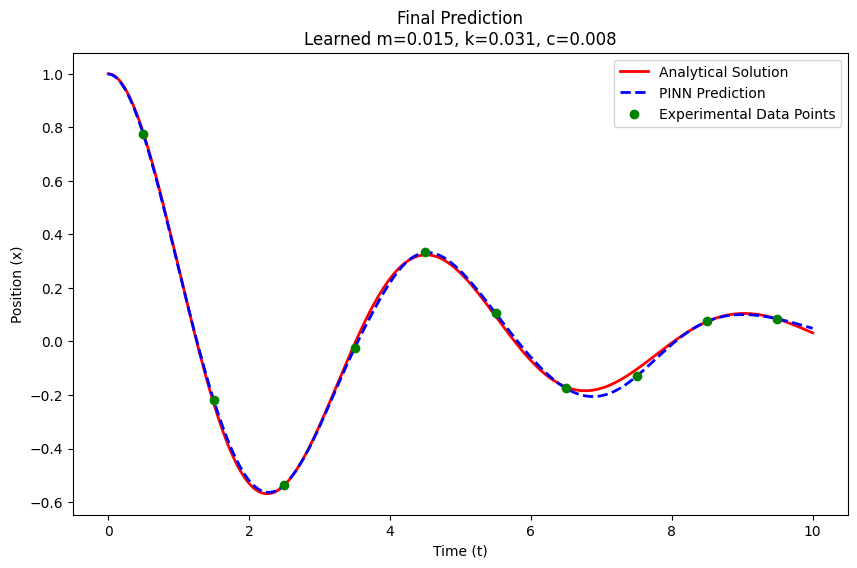

In [4]:
# Final learned parameters
m_final, k_final, c_final = torch.exp(log_m_param), torch.exp(log_k_param), torch.exp(log_c_param)
print("\n--- Training Finished ---")
print(f"True m: {m_true:.2f}, Learned m: {m_final.item():.4f}")
print(f"True k: {k_true:.2f}, Learned k: {k_final.item():.4f}")
print(f"True c: {c_true:.2f}, Learned c: {c_final.item():.4f}")

# Final plot comparing analytical vs learned solution
with torch.no_grad():
    x_predicted = model(t_test).numpy()
plt.figure(figsize=(10, 6))
plt.plot(t_test.numpy(), x_analytical, 'r-', label='Analytical Solution', linewidth=2)
plt.plot(t_test.numpy(), x_predicted, 'b--', label='PINN Prediction', linewidth=2)
plt.scatter(t_data.numpy(), x_data.numpy(), color='green', zorder=5, label='Experimental Data Points')
plt.title(f'Final Prediction\nLearned m={m_final.item():.3f}, k={k_final.item():.3f}, c={c_final.item():.3f}')
plt.xlabel('Time (t)')
plt.ylabel('Position (x)')
plt.legend()
plt.grid(False)
plt.show()